# Setup

In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [4]:
# Import standard dependencies
import cv2, uuid, os, random, time, wget, shutil
import numpy as np; import tensorflow as tf; import tensorflow.keras as tfk
from matplotlib import pyplot as plt
from tensorflow.keras import layers
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [5]:
# Set GPU Growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(f'N.o GPUs: {len(gpus)}')

N.o GPUs: 0


In [6]:
# Create Folder Structures
CWD = os.getcwd()

PATHS = {
    'POS': os.path.join(CWD, 'data', 'positive'),
    'NEG': os.path.join(CWD, 'data', 'negative'),
    'ANC': os.path.join(CWD, 'data', 'anchor'),
    'CHECKPOINT': os.path.join(CWD, 'training_checkpoints', 'ckpt'),
    'MODEL': os.path.join(CWD, 'model'),
    'INFERENCE_DATA': os.path.join(CWD, 'inference_data'),
    'VERIFICATION_IMAGES': os.path.join(CWD, 'inference_data', 'verification_images'),
    'INPUT_IMAGE': os.path.join(CWD, 'inference_data', 'input_image'),
    'APP': os.path.join(CWD, 'app'),
    'APP_MODEL': os.path.join(CWD, 'app', 'model')
}

FILES = {
    'MODEL': os.path.join(PATHS['MODEL'], 'model.h5'),
    'INPUT_IMAGE': os.path.join(PATHS['INPUT_IMAGE'], 'input_image.jpg'),
    'APP_MODEL': os.path.join(PATHS['APP_MODEL'], 'model.h5')
}

# Create the folders
for path in PATHS.values():
    if not os.path.exists(path):
        os.makedirs(path)

# DATA

## Labelled Faces in the Wild Dataset
http://vis-www.cs.umass.edu/lfw/

In [7]:
# # Download the images
# wget.download('http://vis-www.cs.umass.edu/lfw/lfw.tgz')

# # Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

# # Move LFW Images to the following repository data/negative
# for directory in os.listdir(CWD, 'lfw'):
#     for file in os.listdir(os.path.join(CWD, 'lfw', directory)):
#         EX_PATH = os.path.join(CWD, 'lfw', directory, file)
#         NEW_PATH = os.path.join(PATHS['NEG'], file)
#         os.replace(EX_PATH, NEW_PATH)

# # Delete the LFW Folder
# for folder in os.listdir(os.path.join(CWD, 'lfw')):
#     os.rmdir(os.path.join(CWD, 'lfw', folder))
# os.rmdir(os.path.join(CWD, 'lfw'))    
# # Delete lfw file
# os.remove(os.path.join(CWD, 'lfw.tgz'))

## Positive and Anchor Classes

In [8]:
FRAME_WIDTH = 480
FRAME_HEIGHT = 640
FRAME_WIDTH_HALF = FRAME_WIDTH // 2
FRAME_HEIGHT_HALF = FRAME_HEIGHT // 2
BOX_SIZE = 250
BOX_SIZE_HALF = BOX_SIZE // 2

img_black = np.zeros((FRAME_WIDTH, FRAME_HEIGHT, 3), np.uint8)
img_put_face = img_black.copy()
img_put_face[FRAME_WIDTH_HALF-BOX_SIZE_HALF:FRAME_WIDTH_HALF+BOX_SIZE_HALF, 
             FRAME_HEIGHT_HALF-BOX_SIZE_HALF:FRAME_HEIGHT_HALF+BOX_SIZE_HALF, :] = 255


In [9]:
def read_and_cut_frame(cap):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame, (FRAME_HEIGHT_HALF - BOX_SIZE_HALF, FRAME_WIDTH_HALF - BOX_SIZE_HALF),
                  (FRAME_HEIGHT_HALF + BOX_SIZE_HALF, FRAME_WIDTH_HALF + BOX_SIZE_HALF), (0, 255, 0), 2)
    
    frame_cut  = frame[FRAME_WIDTH_HALF-BOX_SIZE_HALF+2:FRAME_WIDTH_HALF+BOX_SIZE_HALF-2,
                       FRAME_HEIGHT_HALF-BOX_SIZE_HALF+2:FRAME_HEIGHT_HALF+BOX_SIZE_HALF-2, :]
    return frame, frame_cut

In [23]:
NUM_IMGS_PER_COLLECTION = 200

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    frame, frame_cut = read_and_cut_frame(cap)

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        for i in range(NUM_IMGS_PER_COLLECTION):
            frame, frame_cut = read_and_cut_frame(cap)
            cv2.putText(frame, f'Collecting Anchor Images: {i+1}/{NUM_IMGS_PER_COLLECTION}',
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imwrite(os.path.join(PATHS['ANC'], f'{uuid.uuid1()}.jpg'), frame_cut)
            
            if cv2.waitKey(1) & 0XFF == ord('q'):
                break
            cv2.imshow('Image Collection', frame)
            time.sleep(0.1)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        for i in range(NUM_IMGS_PER_COLLECTION):
            frame, frame_cut = read_and_cut_frame(cap)
            cv2.putText(frame, f'Collecting Positive Images: {i+1}/{NUM_IMGS_PER_COLLECTION}',
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imwrite(os.path.join(PATHS['POS'], f'{uuid.uuid1()}.jpg'), frame_cut)
            
            if cv2.waitKey(1) & 0XFF == ord('q'):
                break
            cv2.imshow('Image Collection', frame)
            time.sleep(0.1)
    
    # Create a mask on frame with img_put_face
    # frame = cv2.bitwise_and(frame, img_put_face)
    
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## Augmentation

In [10]:
def augment_img(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [129]:
img_type = ['ANC', 'POS']
for img_type_i in img_type:
    for file_name in os.listdir(os.path.join(PATHS[img_type_i])):
        img_path = os.path.join(PATHS[img_type_i], file_name)
        img = cv2.imread(img_path)
        img_augmented = augment_img(img)
        for img in img_augmented:
            cv2.imwrite(os.path.join(PATHS[img_type_i], f'{uuid.uuid1()}.jpg'), img.numpy())

## Preprocess

In [11]:
# GET IMAGE DIRECTORIES
NUM_IMGS_ANCHOR = len(os.listdir(PATHS['ANC']))
NUM_IMGS_POSITIVE = len(os.listdir(PATHS['POS']))
NUM_IMGS_NEGATIVE = len(os.listdir(PATHS['NEG']))
NUM_IMGS_CHOSEN = min(NUM_IMGS_ANCHOR, NUM_IMGS_POSITIVE, NUM_IMGS_NEGATIVE)

anchor = tf.data.Dataset.list_files(os.path.join(PATHS['ANC'], '*.jpg')).take(NUM_IMGS_CHOSEN)
positive = tf.data.Dataset.list_files(os.path.join(PATHS['POS'], '*.jpg')).take(NUM_IMGS_CHOSEN)
negative = tf.data.Dataset.list_files(os.path.join(PATHS['NEG'], '*.jpg')).take(NUM_IMGS_CHOSEN)

In [12]:
# PREPROCESSING - SCALE AND RESIZE
IMG_SIZE_TO_MODEL = (100, 100)

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, IMG_SIZE_TO_MODEL)
    # Scale image to be between 0 and 1 
    img = img / 255.0
    return img

## Labelled Dataset
```
(anchor, positive) => 1,1,1,1,1
(anchor, negative) => 0,0,0,0,0
```

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [208]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'c:\\Users\\acer\\OneDrive\\SPECIALIZATION\\AI\\AI_PROJECTS\\FACE RECOGNITION\\Nicholas Renotte\\data\\anchor\\e32aa5f6-479b-11ed-9d5d-c8e26588544a.jpg',
 b'c:\\Users\\acer\\OneDrive\\SPECIALIZATION\\AI\\AI_PROJECTS\\FACE RECOGNITION\\Nicholas Renotte\\data\\positive\\c50156c7-479b-11ed-889e-c8e26588544a.jpg',
 1.0)

## Build Train and Test Partition

In [14]:
def preprocess_twin(input_img_path, validation_img_path, label):
    input_img_preprocessed = preprocess(input_img_path)
    validation_img_preprocessed = preprocess(validation_img_path)
    return(input_img_preprocessed, validation_img_preprocessed, label)

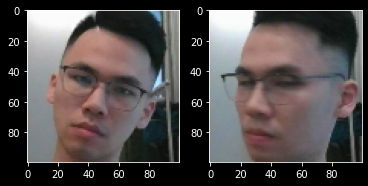

1.0


In [210]:
res = preprocess_twin(*example)
plt.figure()
plt.subplot(121); plt.imshow(res[0])
plt.subplot(122); plt.imshow(res[1])
plt.show()
print(res[2])

In [15]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache().shuffle(buffer_size=1024)

TRAIN_SPLIT = 0.7
TEST_SPLIT = 1 - TRAIN_SPLIT
TRAIN_SIZE = round(len(data)*TRAIN_SPLIT)
TEST_SIZE = round(len(data)*TEST_SPLIT)
BATCH_SIZE = 16
PREFETCH_SIZE = 8

# Training partition
train_data = data.take(TRAIN_SIZE)
train_data = train_data.batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
# Testing partition
test_data = data.skip(TRAIN_SIZE).take(TEST_SIZE)
test_data = test_data.batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

In [212]:
print(data, train_data, test_data, sep='\n\n')

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [213]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
print(len(train_sample),
      len(train_sample[0]), len(train_sample[1]), len(train_sample[2]),
      train_sample[0].shape, train_sample[1].shape, train_sample[2].shape, sep='\n')

3
16
16
16
(16, 100, 100, 3)
(16, 100, 100, 3)
(16,)


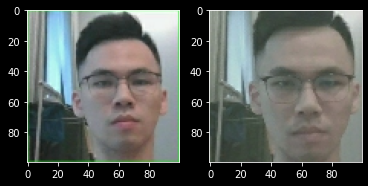

1.0


In [152]:
sample = data.as_numpy_iterator().next()
plt.figure()
plt.subplot(122); plt.imshow(sample[1])
plt.subplot(121); plt.imshow(sample[0])
plt.show()
print(sample[2])

# MODEL

## Building

In [16]:
# Build Embedding Layer

INPUT_SHAPE = IMG_SIZE_TO_MODEL + (3,)
def build_embedding_layer():
    input = layers.Input(shape=INPUT_SHAPE, name='input_image')
    
    x = layers.Conv2D(64, (10, 10), activation='relu', name='block1_conv')(input)
    x = layers.MaxPooling2D(64, (2, 2), padding='same', name='block1_pool')(x)
    x = layers.Conv2D(128, (7, 7), activation='relu', name='block2_conv')(x)
    x = layers.MaxPooling2D(64, (2, 2), padding='same', name='block2_pool')(x)
    x = layers.Conv2D(128, (4, 4), activation='relu', name='block3_conv')(x)
    x = layers.MaxPooling2D(64, (2, 2), padding='same', name='block3_pool')(x)
    x = layers.Conv2D(256, (4, 4), activation='relu', name='block4_conv')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='sigmoid', name='dense')(x)
    
    return tfk.models.Model(inputs=[input], outputs=[x], name='embedding')

embedding_layer = build_embedding_layer()
embedding_layer.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv (Conv2D)        (None, 91, 91, 64)        19264     
                                                                 
 block1_pool (MaxPooling2D)  (None, 46, 46, 64)        0         
                                                                 
 block2_conv (Conv2D)        (None, 40, 40, 128)       401536    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0         
                                                                 
 block3_conv (Conv2D)        (None, 17, 17, 128)       262272    
                                                                 
 block3_pool (MaxPooling2D)  (None, 9, 9, 128)         0 

In [17]:
# Build Distance Layer
# Siamese L1 Distance class
class L1_Dist_Layer(tfk.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__() # Init method - inheritance
    
    # Similarity calculation
    def call(self, embedding_input, embedding_validation): 
        return tf.math.abs(embedding_input - embedding_validation)

l1_layer = L1_Dist_Layer()

In [18]:
def build_siamese_model():
    # Anchor image input in the network
    img_input = tfk.layers.Input(name='img_input', shape=INPUT_SHAPE)
    # Validation image in the network 
    img_validation = tfk.layers.Input(name='img_validation', shape=INPUT_SHAPE)
    # Combine siamese distance components
    distance_layer = L1_Dist_Layer()
    distance_layer._name = 'distance'
    distances = distance_layer(embedding_layer(img_input), 
                               embedding_layer(img_validation))
    # Classification layer 
    classifier = layers.Dense(1, activation='sigmoid', name='classifier')(distances)
    return tfk.models.Model(inputs=[img_input, img_validation],
                            outputs=[classifier], name='siamese_model')

siamese_model = build_siamese_model()
siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_validation (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['img_input[0][0]',              
                                                                  'img_validation[0][0

## Training

In [19]:
loss_func = tfk.losses.BinaryCrossentropy()
optimizer = tfk.optimizers.Adam(1e-4)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=siamese_model)

# Training step
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:-1]
        # Get label
        y = batch[-1]
        # Forward pass
        y_hat = siamese_model(X, training=True)
        loss = loss_func(y, y_hat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss    

In [20]:
# Training loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpochs: {epoch}/{EPOCHS}')
        progbar = tfk.utils.Progbar(len(data))
        
        # Metric Object
        recall = tfk.metrics.Recall()
        precision = tfk.metrics.Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_hat = siamese_model.predict(batch[:-1])
            recall.update_state(batch[-1], y_hat)
            precision.update_state(batch[-1], y_hat)
            progbar.update(idx + 1)
        print(f'Loss: {loss.numpy():.4f} Recall: {recall.result().numpy():.4f} Precision: {precision.result().numpy():.4f}')
        
        if (epoch % 10 == 0):
            checkpoint.save(file_prefix=FILES['CHECKPOINT'])

In [217]:
EPOCHS = 2
train(train_data, EPOCHS)


Epochs: 1/2
44/44 [==============================] - 856s 19s/step
Loss: 0.1337 Recall: 0.8952 Precision: 0.9814

Epochs: 2/2
44/44 [==============================] - 781s 18s/step
Loss: 0.2921 Recall: 0.9553 Precision: 0.9942


## Save & Load

In [218]:
# SAVE MODEL
siamese_model.save(FILES['MODEL'])

In [21]:
# RELOAD MODEL
siamese_model = tfk.models.load_model(FILES['MODEL'], 
                    custom_objects={'L1_Dist_Layer': L1_Dist_Layer, 
                                     'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

## Evaluate

In [226]:
# MAKE PREDICTIONS

# METRICS
recall = tfk.metrics.Recall()
precision = tfk.metrics.Precision()

for test_batch in test_data.as_numpy_iterator():
    test_input, test_val, y_true = test_batch
    y_hat = siamese_model.predict([test_input, test_val])
    recall.update_state(y_true, y_hat)
    precision.update_state(y_true, y_hat)

print(f'Recall: {recall.result().numpy():.4f}\nPrecision: {precision.result().numpy():.4f}')

1/1 [==============================] - 1s 1s/step
Recall: 0.8639
Precision: 1.0000


# REAL-TIME

In [22]:
NUM_IMGS_VERIFICATION = 10
positive_img_names = os.listdir(PATHS['POS'])
idx = np.random.randint(0, len(positive_img_names), NUM_IMGS_VERIFICATION)
positive_img_names = [positive_img_names[i] for i in idx]

# Remove files in PATHS['VERIFICATION_IMAGES']
for file in os.listdir(PATHS['VERIFICATION_IMAGES']):
    os.remove(os.path.join(PATHS['VERIFICATION_IMAGES'], file))

# Copy images to verification folder
for img_name in positive_img_names:
    img_path = os.path.join(PATHS['POS'], img_name)
    shutil.copy(img_path, PATHS['VERIFICATION_IMAGES'])

In [23]:
# VERIFICATION FUNCTION
def verify(model, threshold_detection, threshold_verification):
    results = []
    
    for image in os.listdir(PATHS['VERIFICATION_IMAGES']):
        img_input = preprocess(FILES['INPUT_IMAGE'])
        img_validation = preprocess(os.path.join(PATHS['VERIFICATION_IMAGES'], image))
        # Wrap 02 input img in a list, add 01 more dimension
        result = model.predict(list(np.expand_dims([img_input, img_validation], axis=1)))
        results.append(result)
  
    # Threshold Detection: Metric above which a prediction is considered postitive
    num_detections = np.sum(np.array(results) > threshold_detection)
    # Verification Threshold: Proportion of positive predictions/total positive samples
    num_verifications = num_detections/len(os.listdir(PATHS['VERIFICATION_IMAGES']))
    is_verified = num_verifications > threshold_verification
    
    return results, is_verified

In [26]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
is_verified = None

while cap.isOpened():
    frame, frame_cut = read_and_cut_frame(cap)
    
    # Verification Trigger
    if (cv2.waitKey(10) & 0xFF == ord('v')):
        cv2.putText(frame, 'Verifying...', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Verification', frame)
        if cv2.waitKey(1) & 0XFF == ord('q'): break
        
        cv2.imwrite(FILES['INPUT_IMAGE'], frame_cut)
        results, is_verified = verify(model=siamese_model, 
                                   threshold_detection=0.5, threshold_verification=0.5)
        print(f'Verification: {is_verified}')
    
    if is_verified is not None:
        result = 'Verified' if is_verified else 'Unverified'
    else:
        result = 'Unknown'
    cv2.putText(frame, f'{result}', (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow('Verification', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'): break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 329ms/step
Verification: False
1/1 [==============================] - 0s 262ms/step
Verification: True
1/1 [==============================] - 0s 245ms/step
Verification: False


# App

In [290]:
# Copy inference_data folder to app folder
shutil.copytree(PATHS['INFERENCE_DATA'], os.path.join(PATHS['APP'], 'inference_data'))
# Copy model.h5 file to app folder
shutil.copy(FILES['MODEL'], FILES['APP_MODEL'])

'c:\\Users\\acer\\OneDrive\\SPECIALIZATION\\AI\\AI_PROJECTS\\FACE RECOGNITION\\Nicholas Renotte\\app\\model\\model.h5'